In [806]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.signal import stft
from scipy.fft import fft
from scipy.signal.windows import hann

from fastcore.all import *
from datetime import datetime

In [ ]:
folder = "../data/processed/"
labels = pd.read_csv(folder+'y_train.csv', index_col='id') # read labels
data = pd.read_csv(folder+'/X_train.csv', index_col='id') # read data
data_test = pd.read_csv(folder+'/X_test.csv', index_col='id') # read test data

labels_array_test = np.empty(data_test.shape[0], dtype=object) # dummy labels for test data
labels_array_test[:] = "test"
labels_array_test

In [ ]:
## explore duration of measurements
length_measurements_test_data = [data_test.iloc[i].dropna().to_numpy(dtype='float32').shape[0]/300 for i in range(data_test.shape[0])]
length_measurements_training_data = [data.iloc[i].dropna().to_numpy(dtype='float32').shape[0]/300 for i in range(data.shape[0])]
ted_descr = pd.DataFrame(length_measurements).describe()
trd_descr = pd.DataFrame(length_measurements_training_data).describe()
descr = pd.concat([ted_descr, trd_descr], axis=1)
descr.columns = ['length of measurements test data', 'length of measurements training data']
display(descr)

In [ ]:
# Retrieve one sample recording per class for plotting
labels_array = labels['y'].to_numpy()
num_classes = 4
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_array == class_id)[0]))

# make lists of indexes for each class
indexes = []
for i in [0, 1, 2, 3]:
    indexes.append(np.argwhere(labels_array == i).flatten().tolist())

# Print indices of the sample signals
print(sample_signal_ids)

# Show the data
data.head()

In [ ]:
def plot_fft_for_sample():
    plt.rcParams['axes.labelsize'] = 6
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['ytick.labelsize'] = 6
    plt.figure(figsize=(12, 6))

    def get_sample(): # get random sample of indexes from each class
        return indexes[0][np.random.randint(0, len(indexes[0]), 1)[0]], \
        indexes[1][np.random.randint(0, len(indexes[1]), 1)[0]], \
        indexes[2][np.random.randint(0, len(indexes[2]), 1)[0]], \
        indexes[3][np.random.randint(0, len(indexes[3]), 1)[0]]
        
    sample = get_sample()

    # now plot the sample and the fft
    for i in range(4):
        measurements = data.loc[ sample[i] ].dropna().to_numpy(dtype='float32')

        # Sample ECG data (replace with your actual data)
        # In this example, ecg_data should be a 1-D numpy array containing ECG signal values
        # 'sampling_rate' should be the rate at which the data was sampled
        ecg_data = measurements
        sampling_rate = 300  # measurements per second

        # Perform Fourier Transform
        ecg_fft = fft(ecg_data)
        fft_frequency = np.linspace(0, sampling_rate, len(ecg_data))

        # Compute magnitude of the FFT (since the result is complex)
        magnitude = np.abs(ecg_fft)

        # Plotting the result
        plt.subplot(4,2,2*(i+1)-1)
        plt.plot([i/300 for i in range(len(ecg_data))], ecg_data, lw=0.5, color='k')
        plt.title('Original ECG Signal ['+str(labels_array[sample[i]])+']')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        plt.subplot(4,2,2*(i+1))
        plt.plot(fft_frequency, magnitude, lw=1, color='k')
        plt.title('Magnitude of the FFT of the ECG Signal')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.xlim(0, sampling_rate / 2)  # Limiting x-axis to half the sampling rate as per Nyquist theorem
        plt.tight_layout()

    plt.show()

# Plot the spectrogram of the stft of a sample of signals
def plot_stft_spectrogram_for_sample():
    sampling_rate = 300  # sampling rate of ECG data

    plt.rcParams['axes.labelsize'] = 6
    plt.rcParams['axes.titlesize'] = 6
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['ytick.labelsize'] = 6

    sample = get_sample()

    fig, axs = plt.subplots(2, 2, figsize=(6, 6))  # Create a figure and a 2x2 grid of axes
    
    for i in range(4):
        ax = axs[i//2, i%2]  # Select the appropriate subplot

        # Sample ECG data
        # In this example, ecg_data should be a 1-D numpy array containing ECG signal values
        ecg_data = data.loc[ sample[i] ].dropna().to_numpy(dtype='float32')
        f, t, Zxx = stft(ecg_data, fs=sampling_rate, window='hann', nperseg=400)

        ax.pcolormesh(t, f, np.log(np.abs(Zxx)), shading='gouraud', cmap='jet')
        ax.set_title("Type " + str(labels_array[sample[i]]))
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        ax.set_ylim(0, 150)  # Limiting y-axis to frequencies below 75 Hz
        ax.set_xlim(1.5, 11.5)  # Limiting y-axis to frequencies below 75 Hz

    fig.tight_layout()
    plt.show()

def plot_features(signal):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')

def plot_peak(signal):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')

### Pay attention to NaN values! 

Unlike many medical application, these NaNs **DO NOT** represent missing values but appear because of variable length of the signals. ECG recordings normally don't have missing values and are sampled equally.

Despite being put into a tabular CSV format / Pandas Dataframe, the data is still a raw signal with variable lengths. Coumns *x0, ..., x17806* correspond to measurements at time stamps *0, ..., 17806* and not to different features of the data point. If the signal is too short then all the coumns after the last measurement have NaN values,

## Plot sample signals for each class

First, show me some signals from each class. I want to see if there are any obvious differences between the classes.

In [ ]:
# Some matplotlib setting 
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8

fig, axs = plt.subplots(4, 1, figsize=(10, 5), sharex=True)

seconds = np.arange(0, 600) / 30 
x_labels = [0, 5, 10, 15, 20]

for class_id in range(num_classes):
    ax = axs[class_id]
    #ax.set_title("Class {}".format(class_id))
    
    measurements = data.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[1000:7000:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

Also, look at the **Fourier transform of the signals**, to see whether the different classes can be distinguished well by their frequency spectrum.

In [ ]:
plot_fft_for_sample()

Then look at the **mean and median heartbeat** for a sample from each class.

/var/folders/qm/2f3zskhn7cvc0l4v0r378c2w0000gn/T/ipykernel_22433/1100453727.py:97: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')


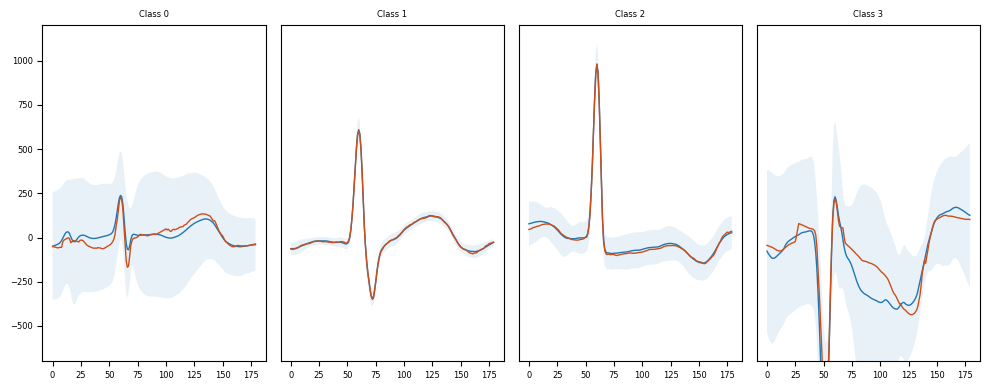

In [835]:
sample = get_sample()
plt.rcParams['lines.linewidth'] = 1
plt.figure(figsize=(10, 4))
for class_id in range(num_classes):
    ax = plt.subplot(1, 4, class_id + 1)
    ax.set_ylim([-700, 1200])
    if class_id:
        ax.set_yticks([])
    plot_features(data.loc[sample[class_id]].dropna().to_numpy(dtype='float32'))
    ax.set_title("Class {}".format(class_id))

plt.tight_layout()
plt.show()

In [825]:
# function for lineplots
def plot_and_save_beats(measurements, show, folderpath, label, id):
    
    r_peaks = ecg.engzee_segmenter(measurements, 300)['rpeaks']
    beats = ecg.extract_heartbeats(measurements, r_peaks, 300)['templates']

    if len(beats) == 0:
        print(f'No beats found for {id}')
        return

    fig, ax = plt.subplots(1,1, figsize=(3, 3));  # Create a figure
    for i in range(beats.shape[0]):
        ax.plot(range(beats[i, :].shape[0]), beats[i, :], label='HeartBeats', color="#000000", linewidth=0.5, alpha=0.2)
    
    mu = np.mean(beats, axis=0) 
    var = np.std(beats, axis=0)
    md = np.median(beats, axis=0)
    
    plt.plot(range(mu.shape[0]), mu)
    # Fill the variance range
    plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
    # Plot a median
    plt.plot(range(md.shape[0]), md, color='#CC4F1B')

    ax.set_ylim([(np.abs(md)).max()*(-2), (np.abs(md)).max()*2])
    ax.set_xticklabels("");
    ax.set_yticklabels("");
    ax.set_xticks([]);
    ax.set_yticks([]);
    fig.tight_layout();

    if show: 
        plt.show()
    (folderpath/f'{label}').mkdir(exist_ok=True)
    fig.savefig(folderpath/f'{label}/lp_{id}_0.png')  # Save the figure
    fig.clf()
    plt.close(fig)

19
4
69
30
17
18
45
56
19
4
69
30
17
18
45
56
19
4
69


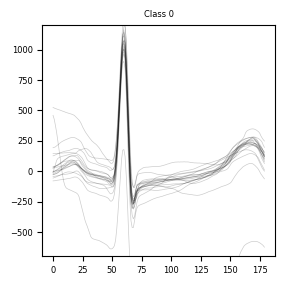

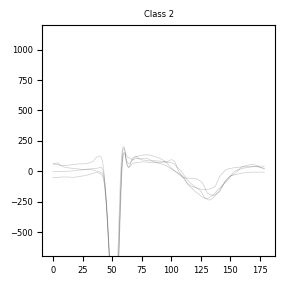

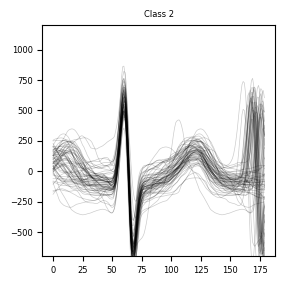

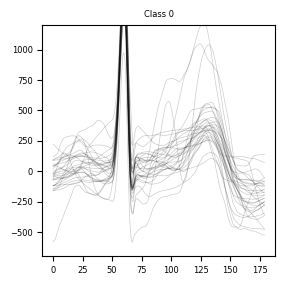

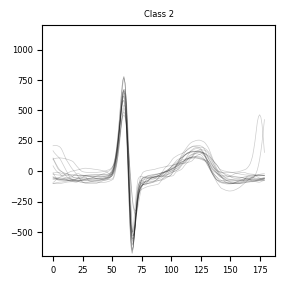

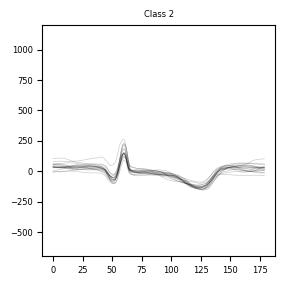

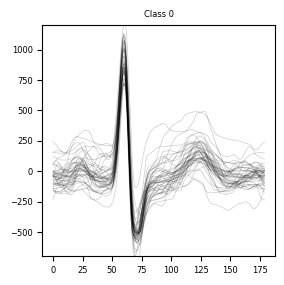

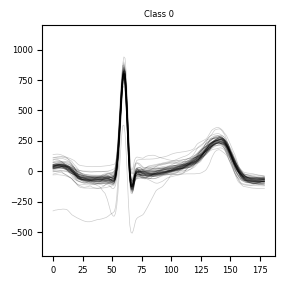

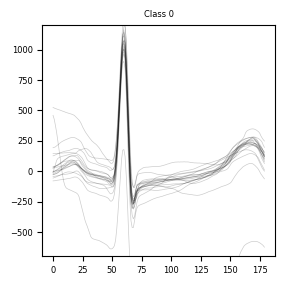

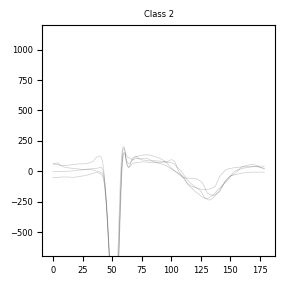

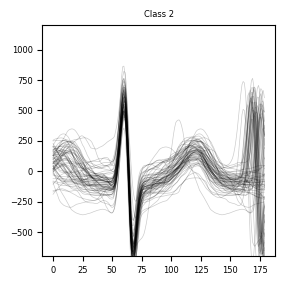

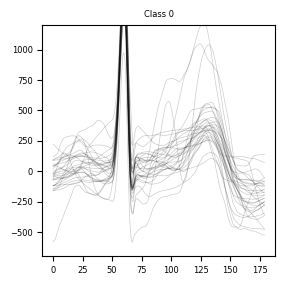

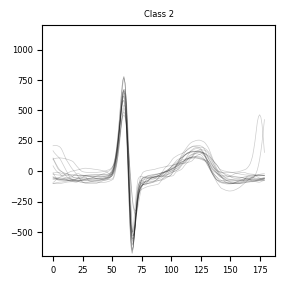

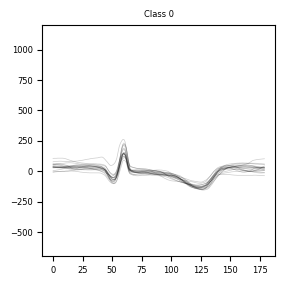

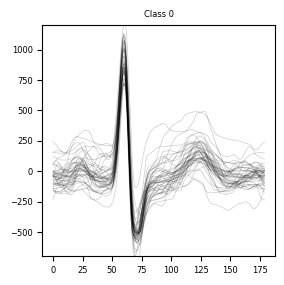

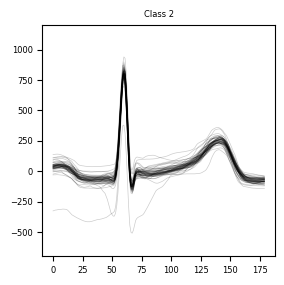

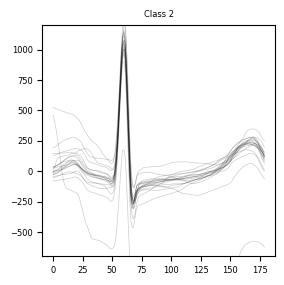

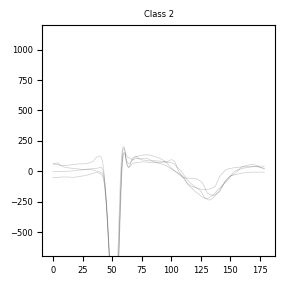

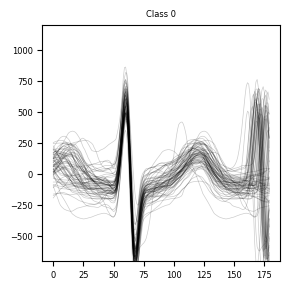

In [845]:
plt.rcParams['lines.linewidth'] = 1
labels_array = labels['y'].to_numpy()

for id in nobeats:
    fig, ax = plt.subplots(1,1, figsize=(3, 3));  # Create a figure
    ax.set_ylim([-700, 1200])
    
    measurements = data.loc[i].dropna().to_numpy(dtype='float32')
    r_peaks = ecg.engzee_segmenter(measurements, 300)['rpeaks']
    beats = ecg.extract_heartbeats(measurements, r_peaks, 300)['templates']
    print(len(beats))
    for i in range(beats.shape[0]):
        ax.plot(range(beats[i, :].shape[0]), beats[i, :], label='HeartBeats', color="#000000", linewidth=0.5, alpha=0.2)

    ax.set_title("Class {}".format(labels_array[id]))

plt.tight_layout()
plt.show()

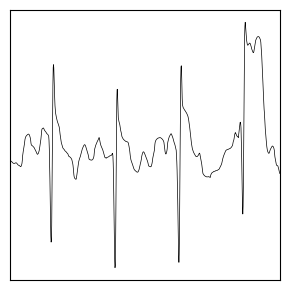

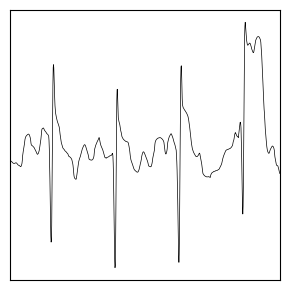

In [884]:
# get the line segment figure
def get_line_segment(measurements, nsec=3, segment=0, show=False, sampling_rate=300):
    
    t_lo = nsec*sampling_rate*(segment) 
    t_up = nsec*sampling_rate*(segment+1)
    if t_up > len(measurements):
        print(f'Index out of range for segment {segment}')
        return None
    fig, ax = plt.subplots(1,1, figsize=(3, 3));  # Create a figure
    
    plt.plot(range(t_lo, t_up), measurements[t_lo:t_up], linewidth=0.5, color='k')

    ax.set_xticklabels("");
    ax.set_yticklabels("");
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.set_xlim(t_lo, t_up);  # Limiting x-axis to the time interval of interest
    fig.tight_layout();
    if show:
        plt.show()
    return fig

get_line_segment(measurements, nsec=3, segment=2, show=True)

Also plot the **short-time Fourier transform** (STFT) to see how the frequency spectrum changes over time. We plot the spectrum as a spectrogram heatmap.

In [ ]:
plot_stft_spectrogram_for_sample()

# Prepare Data (do not run)